In [2]:
from google.colab import files
uploaded = files.upload()

Saving billboard_top.csv to billboard_top.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving spotify_top_2024.csv to spotify_top_2024.csv


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [30]:
spotify = pd.read_csv('spotify_top_2024.csv', encoding='latin1')
billboard = pd.read_csv('billboard_top.csv', encoding='latin1')

print("Spotify Columns:", spotify.columns.tolist())
print("Billboard Columns:", billboard.columns.tolist())

Spotify Columns: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity', 'Explicit Track']
Billboard Columns: ['chart_week', 'current_week', 'title', 'performer', 'last_week', 'peak_pos', 'wks_on_chart']


In [31]:
spotify.columns = spotify.columns.str.lower().str.strip()
billboard.columns = billboard.columns.str.lower().str.strip()

# Rename Spotify columns for consistency
spotify = spotify.rename(columns={
    'track': 'title',
    'artist': 'performer'
})

# Standardize text columns
for df in [spotify, billboard]:
    for col in ['title', 'performer']:
        df[col] = df[col].astype(str).str.lower().str.strip()

In [32]:
# Ensure chart_week is a datetime column
billboard['chart_week'] = pd.to_datetime(billboard['chart_week'], errors='coerce')

# Extract the year from the date
billboard['year'] = billboard['chart_week'].dt.year

# Filter to keep only songs that appeared on Billboard in 2024
billboard_2024 = billboard[billboard['year'] == 2024].copy()

print("Billboard entries for 2024:", len(billboard_2024))
billboard_2024.head()

Billboard entries for 2024: 2300


,chart_week,current_week,title,performer,last_week,peak_pos,wks_on_chart,year
10500,2024-01-06,1,rockin' around the christmas tree,brenda lee,2.0,1,58,2024
10501,2024-01-06,2,all i want for christmas is you,mariah carey,1.0,1,65,2024
10502,2024-01-06,3,jingle bell rock,bobby helms,3.0,3,56,2024
10503,2024-01-06,4,last christmas,wham!,4.0,4,38,2024
10504,2024-01-06,5,a holly jolly christmas,burl ives,5.0,4,39,2024


In [33]:
merged = pd.merge(
    spotify,
    billboard_2024[['title', 'performer', 'peak_pos', 'wks_on_chart']],
    on=['title', 'performer'],
    how='inner'  # only keep songs that appear in both
)

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (1650, 31)


,title,album name,performer,release date,isrc,all time rank,track score,spotify streams,spotify playlist count,spotify playlist reach,...,deezer playlist reach,amazon playlist count,pandora streams,pandora track stations,soundcloud streams,shazam counts,tidal popularity,explicit track,peak_pos,wks_on_chart
0,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,1
1,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,2
2,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,3
3,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,4
4,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,5


In [34]:
features = [
    'spotify streams', 'spotify playlist count', 'spotify playlist reach',
    'spotify popularity', 'youtube views', 'youtube likes',
    'tiktok posts', 'tiktok likes', 'tiktok views'
]

merged = merged.dropna(subset=features + ['peak_pos'])
merged.head()

,title,album name,performer,release date,isrc,all time rank,track score,spotify streams,spotify playlist count,spotify playlist reach,...,deezer playlist reach,amazon playlist count,pandora streams,pandora track stations,soundcloud streams,shazam counts,tidal popularity,explicit track,peak_pos,wks_on_chart
0,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,1
1,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,2
2,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,3
3,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,4
4,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2,5


In [35]:
print(merged.columns.tolist())

['title', 'album name', 'performer', 'release date', 'isrc', 'all time rank', 'track score', 'spotify streams', 'spotify playlist count', 'spotify playlist reach', 'spotify popularity', 'youtube views', 'youtube likes', 'tiktok posts', 'tiktok likes', 'tiktok views', 'youtube playlist reach', 'apple music playlist count', 'airplay spins', 'siriusxm spins', 'deezer playlist count', 'deezer playlist reach', 'amazon playlist count', 'pandora streams', 'pandora track stations', 'soundcloud streams', 'shazam counts', 'tidal popularity', 'explicit track', 'peak_pos', 'wks_on_chart']


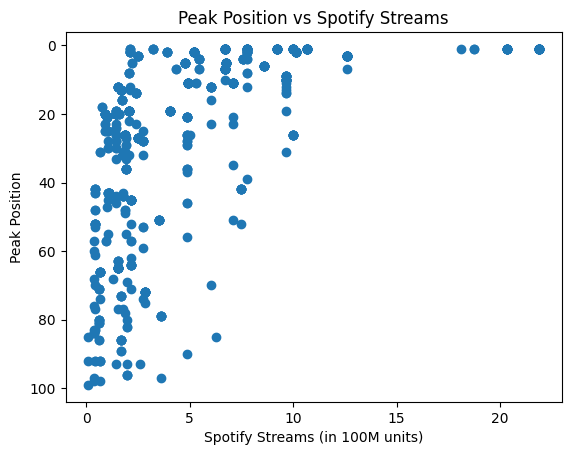

In [49]:
# Make sure the column is numeric
merged['spotify streams'] = pd.to_numeric(merged['spotify streams'], errors='coerce')

# Convert to units of 100 million
merged['Spotify_Streams_100M'] = merged['spotify streams'] / 100_000_000

# Scatter plot vs peak_pos
plt.scatter(merged['Spotify_Streams_100M'], merged['peak_pos'])
plt.xlabel('Spotify Streams (in 100M units)')
plt.ylabel('Peak Position')
plt.title('Peak Position vs Spotify Streams')
plt.gca().invert_yaxis()  # So #1 is at the top
plt.show()

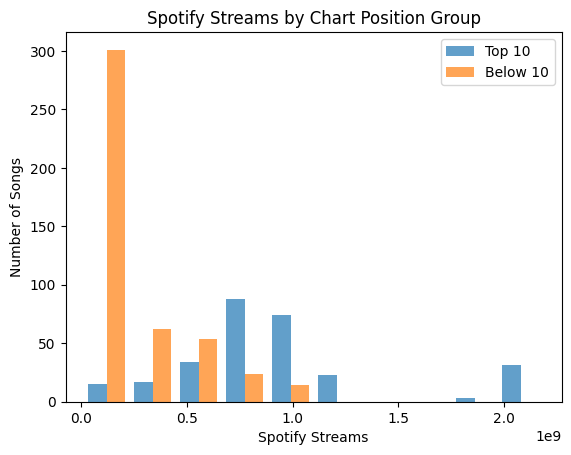

In [17]:
top10 = merged[merged['peak_pos'] <= 10]['spotify streams']
below10 = merged[merged['peak_pos'] > 10]['spotify streams']

plt.hist([top10, below10], bins=10, label=['Top 10', 'Below 10'], alpha=0.7)
plt.xlabel('Spotify Streams')
plt.ylabel('Number of Songs')
plt.title('Spotify Streams by Chart Position Group')
plt.legend()
plt.show()

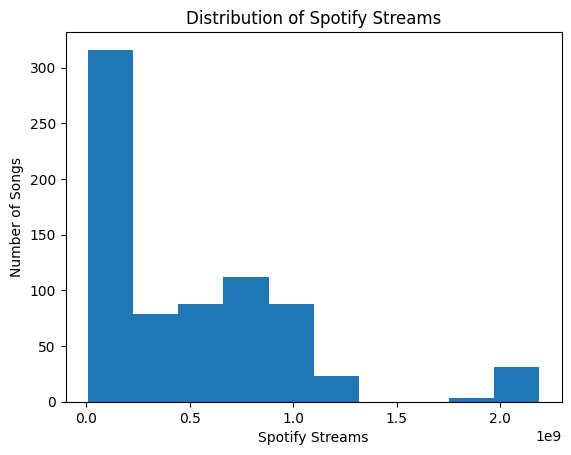

In [19]:
plt.hist(merged['spotify streams'], bins=10)
plt.xlabel('Spotify Streams')
plt.ylabel('Number of Songs')
plt.title('Distribution of Spotify Streams')
plt.show()

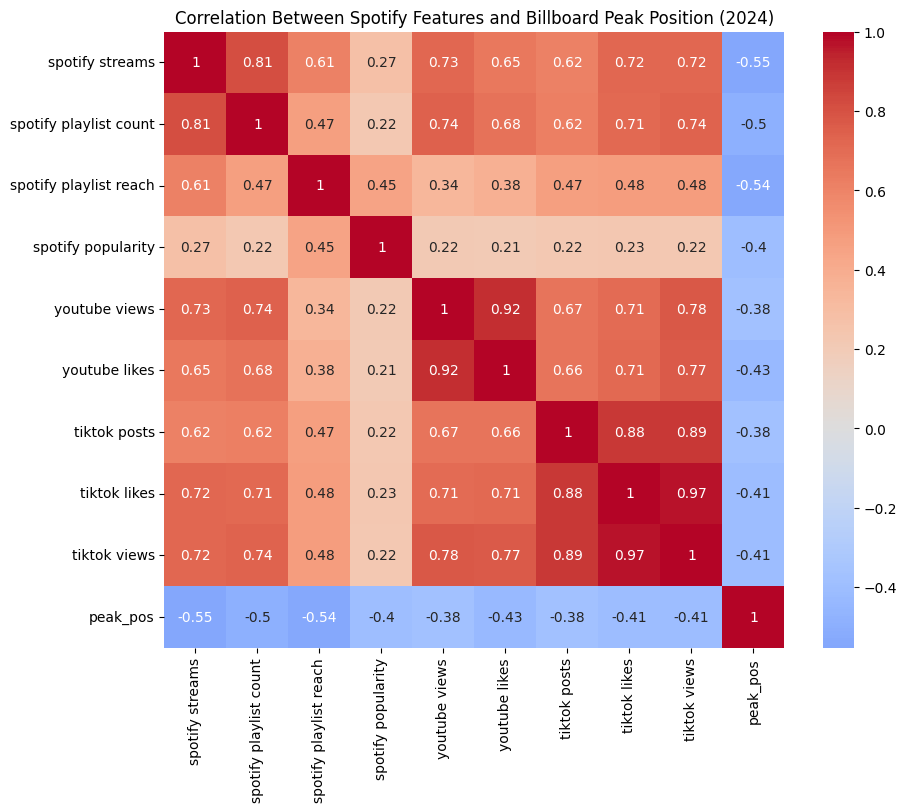

In [11]:
# Clean and convert columns to numeric
for col in features:
    merged[col] = merged[col].astype(str).str.replace(',', '', regex=False)
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Drop rows where conversion failed
merged = merged.dropna(subset=features)

corr = merged[features + ['peak_pos']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Spotify Features and Billboard Peak Position (2024)')
plt.show()

In [12]:
X = merged[features]
y = merged['peak_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.40652599712042536
MAE: 15.935152038277284


/tmp/ipython-input-261122721.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')


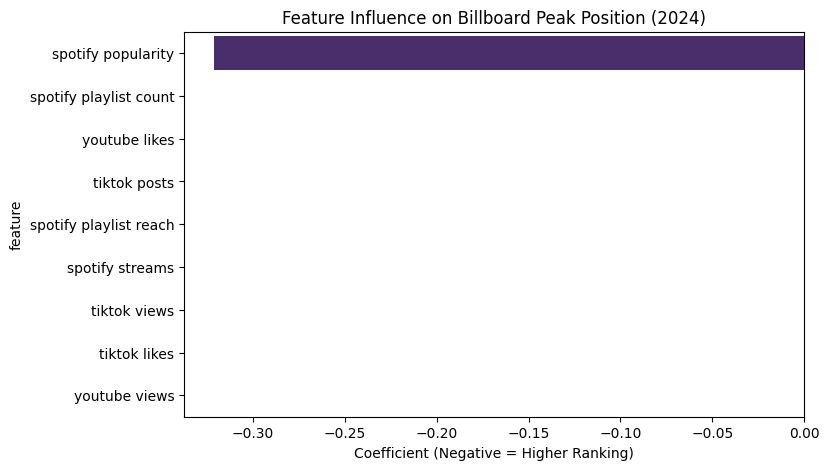

In [13]:
importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values(by='coefficient')

plt.figure(figsize=(8, 5))
sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')
plt.title('Feature Influence on Billboard Peak Position (2024)')
plt.xlabel('Coefficient (Negative = Higher Ranking)')
plt.show()